In [82]:
import jax
from jax import lax, random, numpy as jnp
import flax
import numpy as np
from flax import linen as nn
from flax.training import train_state, checkpoints

In [83]:
print(jax.devices())

[CpuDevice(id=0)]


In [86]:
model_name = "MLP_w_att_69099_st1000000_1000000"
CHECKPOINTS_DIR = "ckpts_maja_T3"
prefix = f"checkpoint_{model_name}"
restored_state = checkpoints.restore_checkpoint(ckpt_dir=CHECKPOINTS_DIR, target=None, prefix=prefix)
restored_params = restored_state["params"]["VmapMLP_wavelength_att_0"]
# jax.tree_map(lambda x: x.shape, restored_params)

In [116]:
# log_wave = np.linspace(np.log10(3800),np.log10(9800),100000)
log_wave = np.linspace(np.log10(4000),np.log10(4100),10000)
log_wave

array([3.60205999, 3.60206106, 3.60206214, ..., 3.61278171, 3.61278278,
       3.61278386])

### Parameters scalling

In [117]:
labels_names = ['Teff', 'logg', 'Vturb', 'FeH', 
          'C', 'N', 'O', 'Li', 'Mg', 'Si', 
          'Ca', 'Ti', 'Na', 'Mn', 'Co', 
          'Ni', 'Ba', 'Sr', 'Eu', 'Fe']

max_params = np.array([np.log10(7999.0), 5.5, 2.0, 0.5, 10.0512, 
                       9.4641, 10.2513, 3.9998, 8.8423, 
                       8.886, 7.4469, 6.022, 7.7607, 
                       6.2947, 6.4165, 7.2375, 4.7222, 
                       5.2535, 2.9325, 8.0])

min_params = np.array([np.log10(2500.0), -0.49, 0.5, -4.998, 2.5942, 
                       2.0183, 3.5896, -0.9999, 2.2702, 
                       2.3443, 1.1272, -0.3188, 0.3513, 
                       -0.4472, -0.2082, 0.7536, -3.6691, 
                       -3.0606, -5.4177, 2.5016])
len(labels_names)

20

## Try model

In [118]:
def frequency_encoding(x, min_period, max_period, dimension):
    periods = jnp.logspace(jnp.log10(min_period), jnp.log10(max_period), num=dimension)
    
    y = jnp.sin(2*jnp.pi/periods*x)
    return y

class MLP_single_wavelength_att(nn.Module):
    @nn.compact
    def __call__(self, x):
        p, w = x
        enc_w = frequency_encoding(w, min_period=1e-5, max_period=1.0, dimension=128)
        enc_w = enc_w[None, ...]
        p = nn.gelu(nn.Dense(4*128)(p))
        p = nn.Dense(16*128)(p)
        enc_p = jnp.reshape(p, (16, 128))
        
        # print(enc_p.shape, enc_w.shape)
        # [batch_sizes…, length, features]
        x = enc_w
        for _ in range(10):
            x = x + nn.MultiHeadDotProductAttention(num_heads=8)(inputs_q=x, inputs_kv=nn.LayerNorm()(enc_p))
            x = x + nn.Dense(128)(nn.gelu(nn.Dense(256)(nn.LayerNorm()(x))))
        
        x = nn.gelu(nn.Dense(256)(x[0]))
        x = nn.gelu(nn.Dense(256)(x))
        x = nn.Dense(2)(x)
        return x
    
class MLP_wavelength_att(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, train):
        p, log_waves = inputs
        
        DecManyWave = nn.vmap(
                    MLP_single_wavelength_att, 
                    in_axes=((None, 0),),out_axes=0,
                    variable_axes={'params': None}, 
                    split_rngs={'params': False})
        
        x = DecManyWave(name="decoder")((p, log_waves))
        return x

print("Models defined.")

Models defined.


In [119]:
m = MLP_wavelength_att()
test_parameters = 0.5*jnp.ones((20,))
dummpy_input = (test_parameters, jnp.zeros_like(log_wave))

rng = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}
params = m.init(rng, dummpy_input, False)['params']

flux = m.apply({'params': restored_params}, 
                (test_parameters, log_wave), 
                train=False
               )

<IPython.core.display.Javascript object>


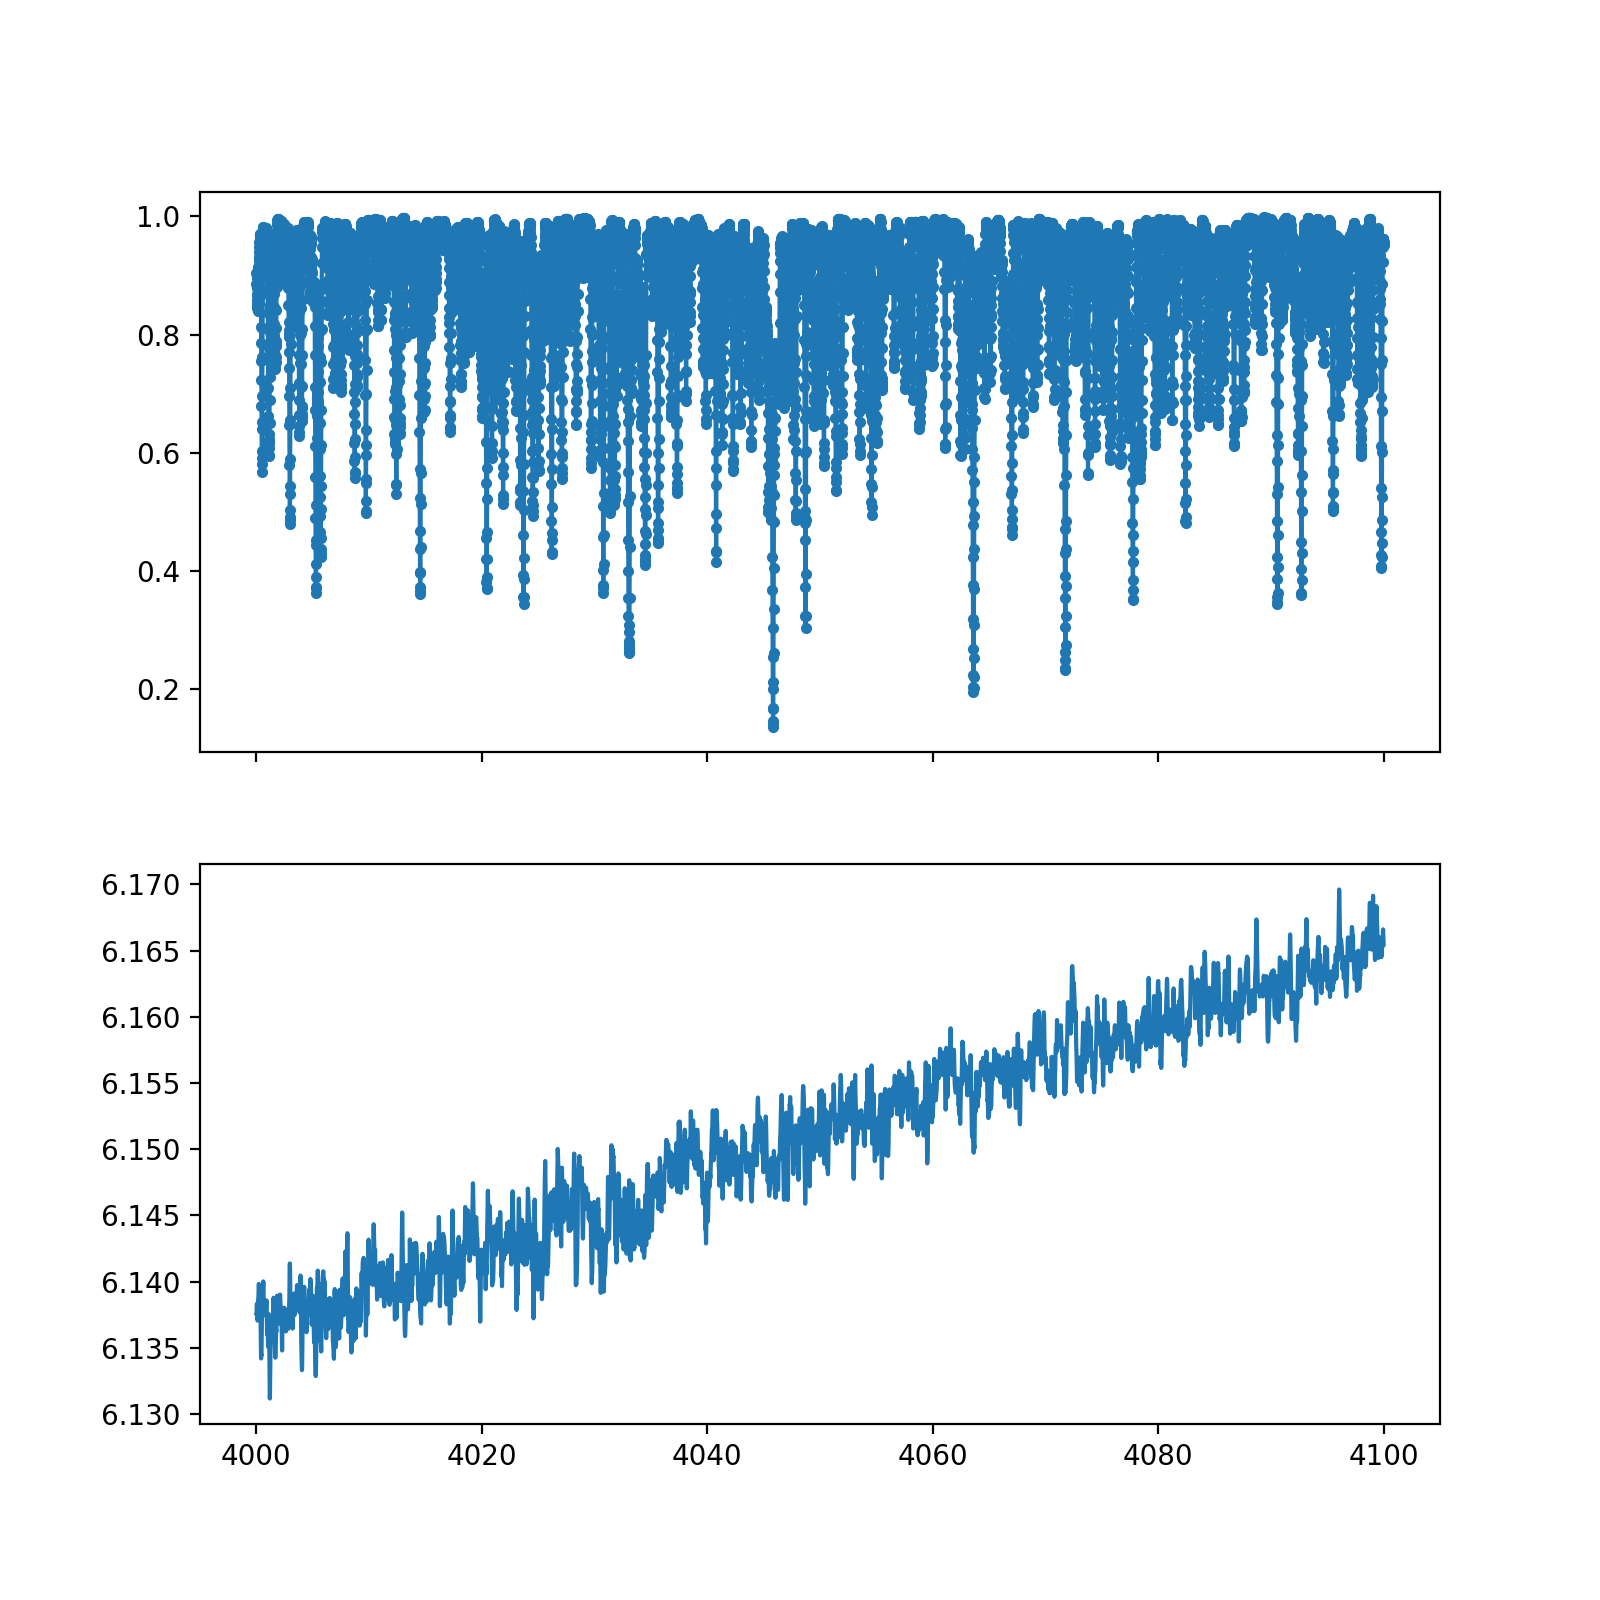

In [120]:
import matplotlib.pyplot as plt
%matplotlib notebook


fig, axs = plt.subplots(nrows=2,figsize=(8,8),sharex=True)
axs[0].plot(10**log_wave, flux[:,0],".-")
axs[1].plot(10**log_wave, flux[:,1])

### Include limb darkening into model predicting single wavelength

In [111]:
class MLP_single_wavelength_att(nn.Module):
    @nn.compact
    def __call__(self, x):
        p, w = x
        enc_w = frequency_encoding(w, min_period=1e-5, max_period=1.0, dimension=128)
        enc_w = enc_w[None, ...]
        p = nn.gelu(nn.Dense(4*128)(p))
        p = nn.Dense(16*128)(p)
        enc_p = jnp.reshape(p, (16, 128))
        
        # print(enc_p.shape, enc_w.shape)
        # [batch_sizes…, length, features]
        x = enc_w
        for _ in range(10):
            x = x + nn.MultiHeadDotProductAttention(num_heads=8)(inputs_q=x, inputs_kv=nn.LayerNorm()(enc_p))
            x = x + nn.Dense(128)(nn.gelu(nn.Dense(256)(nn.LayerNorm()(x))))
        
        x = nn.gelu(nn.Dense(256)(x[0]))
        x = nn.gelu(nn.Dense(256)(x))
        x = nn.Dense(2)(x)
        return x
    
class MLP_wavelength_att_mu(nn.Module):
    
    @nn.compact
    def __call__(self, inputs, train):
        log_waves, mu, p = inputs
        
        A = jnp.log10(0.6*(mu + 2/3)) # Gray atmosphere
        
        DecManyWave = nn.vmap(
                    MLP_single_wavelength_att, 
                    in_axes=((None, 0),), out_axes=0,
                    variable_axes={'params': None}, 
                    split_rngs={'params': False})
        
        x = DecManyWave(name="decoder")((p, log_waves))
        x = x.at[:,1].add(A)
        return x

In [112]:
m = MLP_wavelength_att_mu()
dummpy_input = (jnp.zeros_like(log_wave), 0.0, jnp.zeros((20,)))
test_parameters = 0.5*jnp.ones((20,))

rng = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}
params = m.init(rng, dummpy_input, False)['params']

flux_1 = m.apply({'params': restored_params}, 
                (log_wave,0.0,test_parameters), 
                train=False
               )

flux_2 = m.apply({'params': restored_params}, 
                (log_wave,0.5,test_parameters), 
                train=False
               )

<IPython.core.display.Javascript object>


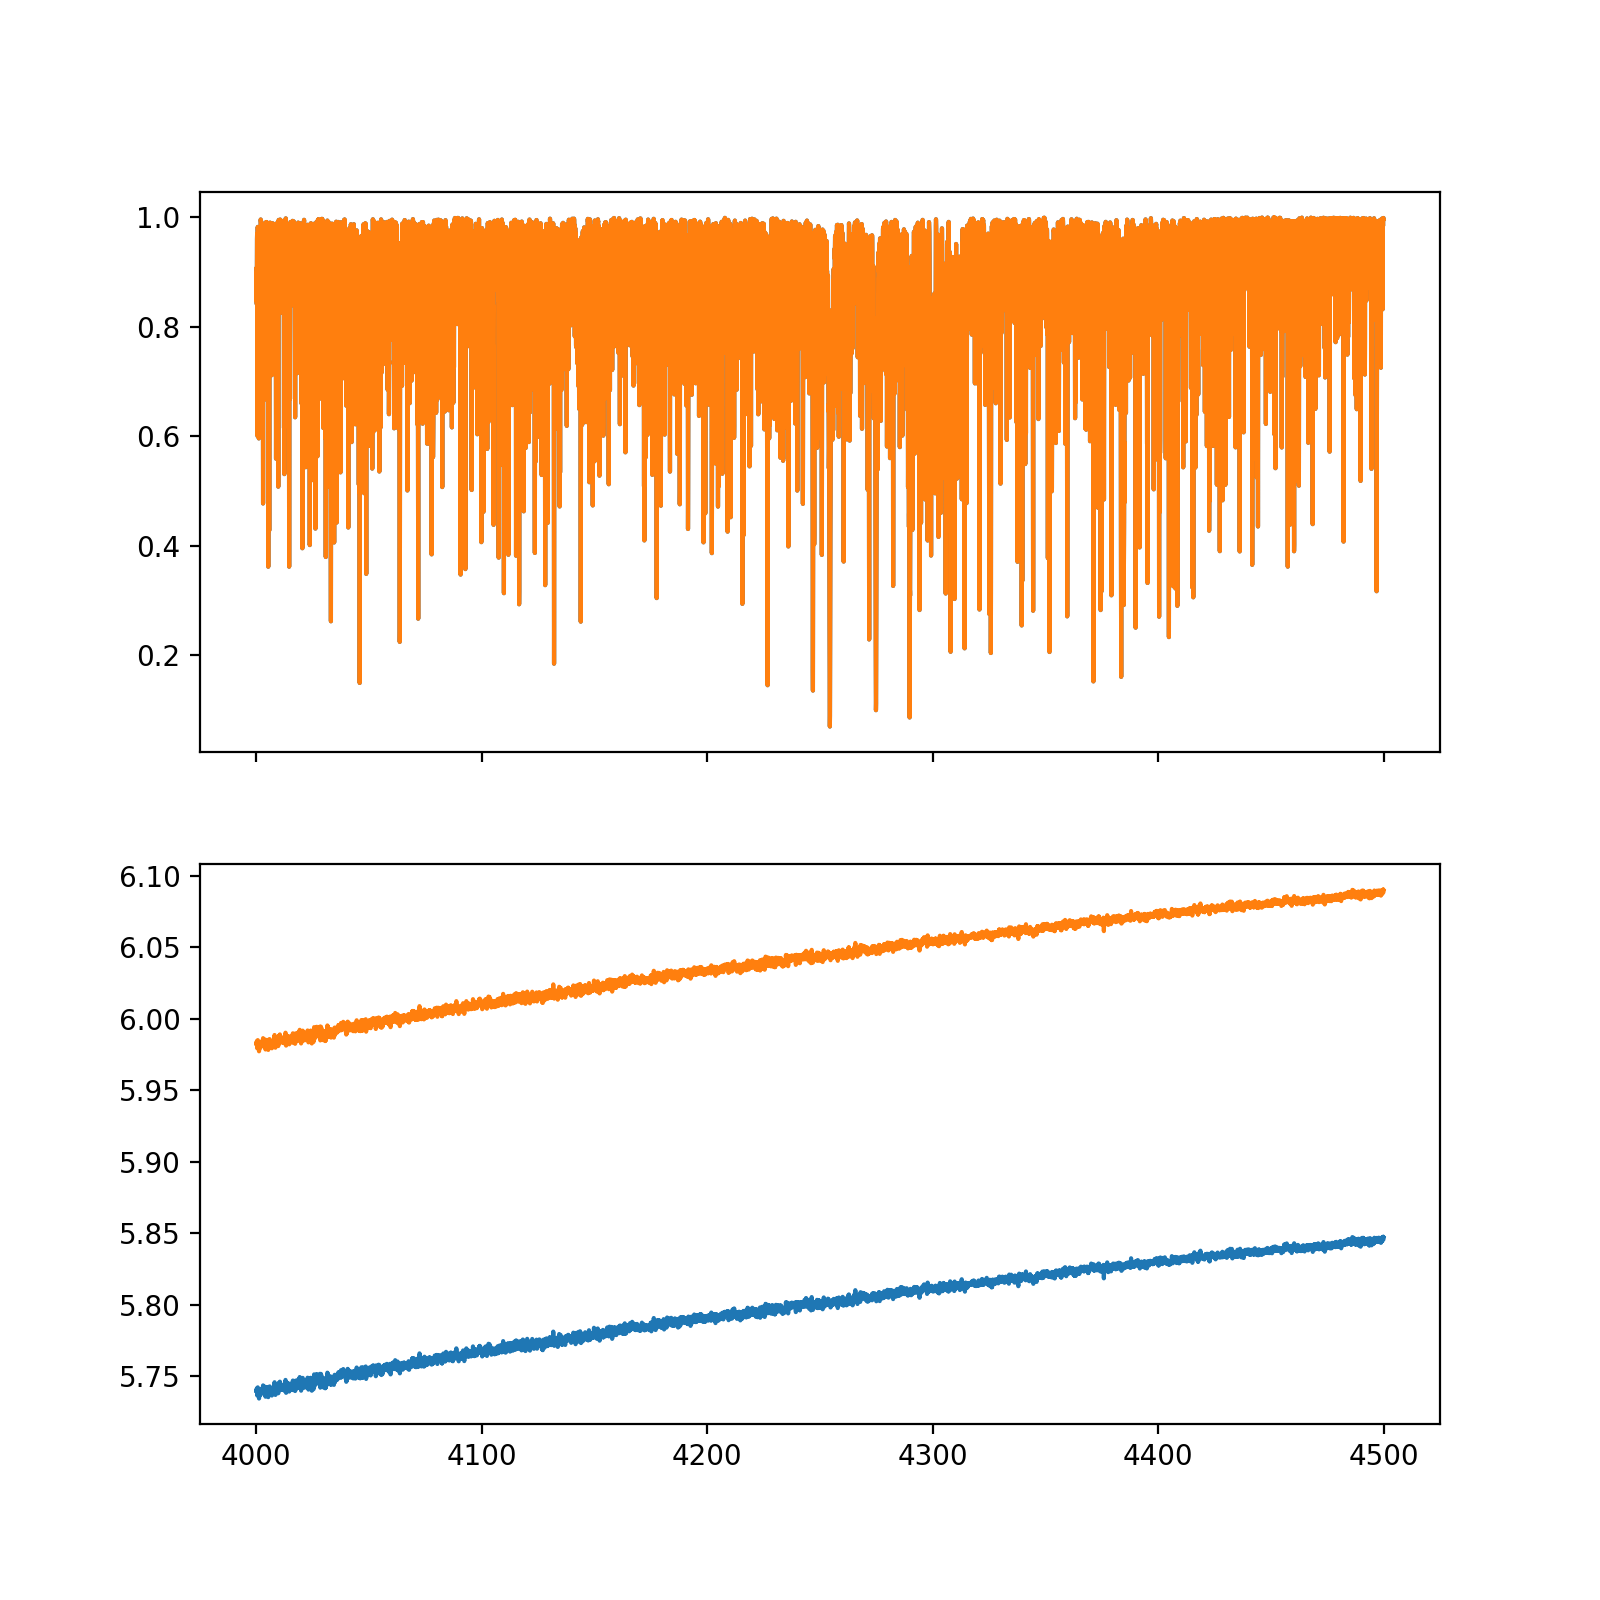

In [114]:
import matplotlib.pyplot as plt
%matplotlib notebook


fig, axs = plt.subplots(nrows=2,figsize=(8,8),sharex=True)
axs[0].plot(10**log_wave, flux_1[:,0])
axs[0].plot(10**log_wave, flux_2[:,0])

axs[1].plot(10**log_wave, flux_1[:,1])
axs[1].plot(10**log_wave, flux_2[:,1])

### Small time measurements

In [130]:
import time

log_wave = np.linspace(np.log10(4000),np.log10(4100),10000)

In [131]:
m = MLP_wavelength_att_mu()
dummpy_input = (jnp.zeros_like(log_wave), 0.0, jnp.zeros((20,)))
test_parameters = 0.5*jnp.ones((20,))

rng = {'params': jax.random.PRNGKey(0), 'dropout': jax.random.PRNGKey(1)}
params = m.init(rng, dummpy_input, False)['params']

In [132]:
start = time.time()
flux_1 = m.apply({'params': restored_params}, 
                (log_wave,0.0,test_parameters), 
                train=False
               ).block_until_ready()
print(f"Elapsed time = {time.time() - start:.3f} sec")

Elapsed time = 1.901 sec
